In [22]:
from __future__ import absolute_import, division, print_function


# UNDER CONSTRUCTION


## Imports

In [23]:
import copy
import glob
import json
import os
import pickle
import random
import re
import sys
import time
from collections import Counter

import googlemaps
import matplotlib as mpl
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import requests
import scipy.stats as ss
from sklearn.datasets.species_distributions import construct_grids
from sklearn.neighbors.kde import KernelDensity

%matplotlib inline



## Functions

In [24]:
# Find local maxima
def find_local_max(inarr,win=3,style='mode',level=3,**kwargs):
    """
    Find the local maxima in an array.
    
    The input array should be a (NxN) numpy array.
    
    A window of size (win)x(win) is used.
    Window size win needs to be an odd number
    to have a defined center pixel. If win is even, 
    it is automtically increased by +1.
    
    The output is a mask of size equal to the input array 
    (NxN) with 0, unless a pixel is identified as a maximum.
    
    The maxima are evaluated base on 'style' using 'level'. 
    E.g., for 'style=mode' and 'level=3', a local maximum if 
    found is retained if its value is 3 times the mode of the
    image.
    """
    # check input
    if win%2 == 0:
        win += 1
    # create empty mask
    shp = inarr.shape
    mask = np.zeros(shape=shp)
    # central index of window
    win_idx = int(np.floor(win/2.)) 
    cen_idx = (win_idx,win_idx)
    win_mask = np.zeros(shape=(win,win))
    win_mask[cen_idx] = 1
    comp_mask = win_mask == 0
    val_mask = win_mask == 1
    xlen = len(inarr[:,0])
    ylen = len(inarr[:,1])
    # determine more in array
    inarr_ravel = inarr[inarr > -9998.0].ravel()
    tmp_list = np.ndarray.tolist(inarr_ravel)
    if style == 'mean':
        tmp_mode = np.mean(inarr_ravel)
        print('Using MEAN for cutoff: ', tmp_mode)
    elif style == 'median':
        tmp_mode = np.median(inarr_ravel)
        print('Using MEDIAN for cutoff: ', tmp_mode)
    elif style == 'bkg':
        tmp_mode = find_background(inarr,**kwargs)
        print('Using BKG for cutoff: ', tmp_mode)
    else:
        tmp_mode = Counter(tmp_list).most_common(1)[0][0]
        print('Using MODE for cutoff: ', tmp_mode)
    cutoff = level*tmp_mode
    for xidx,xin in enumerate(inarr[:,0]):
        for yidx,yin in enumerate(inarr[0,:]):
            sub_arr = inarr[xidx-win_idx:xidx+win_idx+1,yidx-win_idx:yidx+win_idx+1]
            if sub_arr.shape != (win,win):
                pass
            else:
                comp_vals = sub_arr[comp_mask]
                mid_val = sub_arr[val_mask]
                check = [False if x < mid_val else True for x in comp_vals]
                if (sum(check) == 0) and (mid_val > cutoff):
                    mask[xidx,yidx] = int(1)
    final_mask = mask == 1
    return final_mask, cutoff


In [25]:
# Determine background
def find_background(inarr,patch=3,method='median',n_samples=50):
    """
    Find the background value in a 1D array.
    
    Randomly sample the array at 'n_samples' locations. Take 
    metric as set by 'style' within region with side length 
    +/- 'patch'. 
    
    Returns background value of array.
    """
    inarr = inarr[inarr > -9998.0]
    dim = inarr.shape[0]
    nidx = np.random.randint(0,dim-1,n_samples)
    bkg_vec = []
    for idx in nidx:
        tmp_patch = inarr[idx-patch:idx+patch+1]
        try:
            if method == 'mean':
                tmp_val = np.mean(tmp_patch)
            else:
                tmp_val = np.median(tmp_patch)
            bkg_vec.append(tmp_val)
        except:
            pass
    if method == 'mean':
        return np.nanmean(bkg_vec)
    else:
        return np.nanmedian(bkg_vec)



In [26]:
# determine distance between points
def node_dist(invals,incoords,peaks,threshold):
    mask = np.zeros(invals.shape)
    tmp_print = True
    for xidx,xin in enumerate(invals[:,0]):
        for yidx,yin in enumerate(invals[0,:]):
            value = invals[xidx,yidx]
            if value <= threshold:
                pass
            else:
                peaks = np.asarray(peaks)
                dist_2 = np.sum((peaks - incoords[yidx][xidx].reshape(1, -1))**2, axis=1)
                mask[xidx,yidx] =  np.argmin(dist_2) + 1
    return mask



# TargAd
## Advertise where it matters

## Motivation

When running an advertisemt campaign, one important metric to optimize is consumer engagement. And one way to accomplish this is by employing *targeted advertisement*. The idea is that matching the subject matter of the advertisement with the interests of a consumer cohort will increase positive consumer engagement.  

The following examples illustrate this approach:

[//]: # "img/football_01.jpg"
[//]: # "img/football_02.jpg"
[//]: # "img/football_03.jpg"
[//]: # "img/football_04.jpg"

<div>
    <img src="http://payload41.cargocollective.com/1/3/124200/3136336/fb_arkansas_hawgs_ad_o.jpg" alt="title" style="width: 250px; display:inline-block;">
    <img src="https://lh5.googleusercontent.com/-bx6fF7WIJaA/TfCV8r4uRRI/AAAAAAAADVg/HkEq-UYfuwA/s800/bus-stop-ads-soccer-football.jpg" alt="title" style="width: 250px; display:inline-block;">
</div>
<div>
    <img src="https://getwellfed.files.wordpress.com/2009/12/football_layout_final.jpg" alt="title" style="width: 250px; display:inline-block;">

    <img src="https://aotw-pd.s3.amazonaws.com/images/Decathlon-Kipsta-The-Cactus.jpeg" alt="title" style="width: 250px; display:inline-block;">
</div>



It is clear that all of these advertisements have 'football' as the central subject - whatever your favorite type of football may be. Consumer that are interested in the subject will surely engage positively with the Ad, and by extension with the product. 

It is interesting to note that only two of the four examples above advertise for a product that is directly related to the subject matter. Targeted advertisement is a very powerful and generalizable tool.

Let's say your marketing department has created a new Ad campaign with a specific subject matter. The next obvious question will be: where should this Ad be run? And this is where <a href="http://targad.me">TargAd</a> comes in. TargAd allows you to pinpoint the locations where consumer interests are most relevant for the subject matter of your Ad. 


## Technical summary: Tl;dr

TargAd is based on the meta data of Flickr images (tags, titles, location) in the larger Bay Area. When submitting a search term - which should best describe the subject matter of your advertisement - any records matching the term are returned. (Currently, simple string matching is performed). 

The matching records are then used to create a kernel density estimate map (KDE) of the geographical locations. On this KDE map the code identifies local maxima which I interpret as the locations that are most relevant to the search term (and by extension, the subject matter of the advertisement). A ranking of these maxima is provided by counting the strength of the individual 'clusters' (with the maxima being the cluster centers). 

The ranked locations are then provided to the user via a dynamic web application written in Python using the Django web framework. Location and rank are overlayed ontop a Google Maps interface. Additional information like the zip code for the location is also supplied.

Since the cost of running an advertisement depends on the zip code (and the population density in this zip code), having this extra information allows the analyst to make decision as to where the advertisemnt should be run depending on budegt and goals.


## What really happens under the hood...

## Data and preliminaries

A note on the data: In the production environment, queries are run via SQL. For development, it was more convenient to work with a (pickled) pandas data frame.

In [27]:
# import cleaned and pickled dataframe
try:
    flickr_all_clean.shape
except:
    start_time = time.time()
    flickr_all_clean = pd.read_pickle(os.path.join('..','..','data','flickr_all_clean.df'))
    print("--- %s seconds ---" % (time.time() - start_time))



In [28]:
# Select records. 'title_tags' is a string field combining the title and the tags.
# For demonstration, let's use the same example as above.
# In the dynamic website at TargAd.me, the user would provide the keyword via an input text box.
keyword = 'football'
df = flickr_all_clean[flickr_all_clean['title_tags']
                      .str.contains(keyword, na=False)]
print(df.shape)

(18104, 8)


In [29]:
# Get CA coordinates - needed to plot the outline of the coast
try:
    x_coords
    y_coords
except:
    infile = os.path.join('..','..','data','ca_shape.csv')
    ca_shape = pd.read_csv(infile)
    x_coords = ca_shape['longitude'].tolist()
    y_coords = ca_shape['latitude'].tolist()



In [30]:
# Set coordinates for window
limit_lng = [-123.194178,-121.375941]
limit_lat = [36.911135,38.202246]


In [31]:
# Extract longitude and latitude of each returned record into numpy arrays
if len(limit_lng) != 0 and len(limit_lat) != 0:
    yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                    (df['longitude'] < limit_lng[1]) & 
                                    (df['latitude'] > limit_lat[0]) & 
                                    (df['latitude'] < limit_lat[1])].tolist()))

    xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                   (df['longitude'] < limit_lng[1]) & 
                                   (df['latitude'] > limit_lat[0]) & 
                                   (df['latitude'] < limit_lat[1])].tolist()))
else:
    yin = np.array((df['longitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
    xin = np.array((df['latitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))



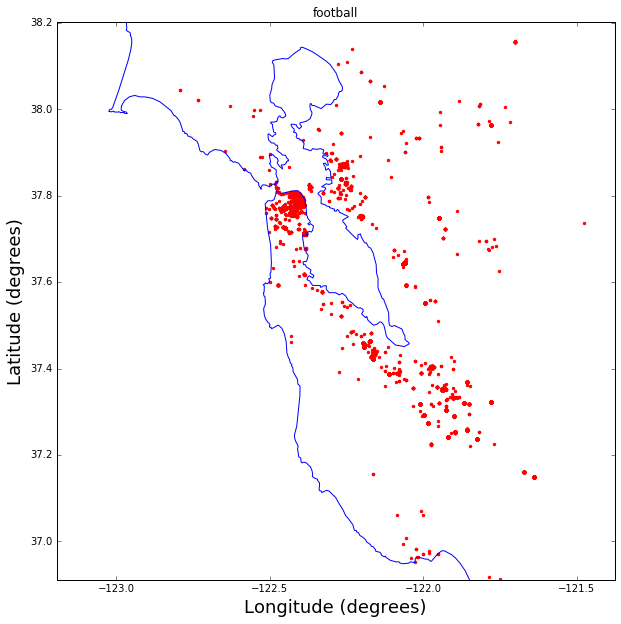

In [32]:
# Show the datapoints only
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot CA outline
plt.plot(x_coords,y_coords)
plt.scatter(yin,xin,5.8,color='red')
plt.xlim(limit_lng[0],limit_lng[1])
plt.ylim(limit_lat[0],limit_lat[1]) 
plt.xlabel('Longitude (degrees)', fontsize=18)
plt.ylabel('Latitude (degrees)', fontsize=18)
#
plt.title(keyword)
#
# outname = os.path.join('img/points_only.png')
# plt.savefig(outname,bbox_inches='tight')
plt.show()

## Run Kernel Density Estimate

In [33]:
# build array from coordinates
# XY = np.vstack([yin.ravel(), xin.ravel()]).T
Xtrain = np.vstack([xin,yin]).T
# Convert lat/long to radians
Xtrain *= np.pi / 180.  
# Set bandwidth - corresponds approximately to the size of zip code regions
band = 0.0003
# Run KDE
kde = KernelDensity(bandwidth=band,algorithm='ball_tree',rtol=1e-4)
kde.fit(Xtrain)
# Set up the data grid on which to evaluate the KDE fit
# Set grid limits
lng_max = limit_lng[0]
lng_min = limit_lng[1]
lat_max = limit_lat[0]
lat_min = limit_lat[1]
# Make the grid
xgrid = np.linspace(lng_min,lng_max,100)
ygrid = np.linspace(lat_min,lat_max,100)
X, Y = np.meshgrid(xgrid, ygrid)
# Restructure data
xy = np.vstack([Y.ravel(), X.ravel()]).T
# I want to evaluate the results only on land. Mask grid elements that do not fall on land.
# Create path for CA 
bbPath = mplPath.Path(np.transpose(np.array((x_coords,y_coords))),closed=True)
patch_time = time.time()
land_mask = np.zeros(xy.shape[0], dtype=bool)
# Mask grid elements
for idx,tmp_coords in enumerate(xy):
    land_mask[idx] = bbPath.contains_point((tmp_coords[1], tmp_coords[0]))
print("--- Masking: %s seconds ---" % (time.time() - patch_time))
# Populate non-masked (i.e. land) elemnst of grid with KDE fit
# Convert lat/long to radians
xy *= np.pi / 180. 
xy = xy[land_mask]
Z = -9999 + np.zeros(land_mask.shape[0])
Z[land_mask] = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)
land_mask_reshape = land_mask.reshape(X.shape)

--- Masking: 5.12141919136 seconds ---


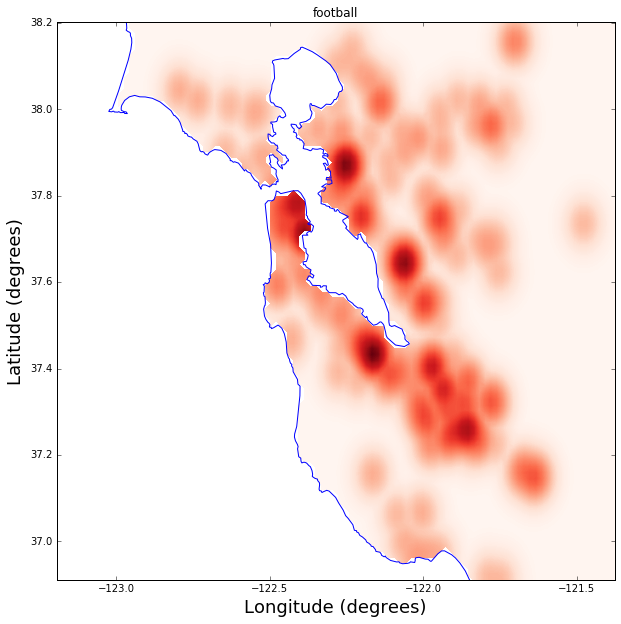

In [34]:
# Show the KDE map
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot CA outline
plt.plot(x_coords,y_coords)
# plot KDE map
Z_new = np.power(Z/np.nanmax(Z),1/6)
levels = np.linspace(0,np.nanmax(Z_new), 150)
plt.contourf(X, Y, Z_new, levels=levels, cmap=plt.cm.Reds)
plt.xlim(limit_lng[0],limit_lng[1])
plt.ylim(limit_lat[0],limit_lat[1]) 
plt.xlabel('Longitude (degrees)', fontsize=18)
plt.ylabel('Latitude (degrees)', fontsize=18)
#
plt.title(keyword)
#
# outname = os.path.join('img/points_only.png')
# plt.savefig(outname,bbox_inches='tight')
plt.show()

## Find local maxima in KDE map

In [35]:
# Find local maxima in KDE map
level = 5
method = 'median'
local_maxima_map, cutoff = find_local_max(Z,win=5,style='mode', 
                                          level=level,patch=5,method=method,
                                          n_samples=100)
new_cutoff = level*cutoff
print("Cutoff used (cutoff x level): ", cutoff)
xy_maxima = np.array((X.reshape(local_maxima_map.shape)[local_maxima_map],
                      Y.reshape(local_maxima_map.shape)[local_maxima_map])).T
z_maxima = np.array((Z.reshape(local_maxima_map.shape)[local_maxima_map])).T
# z_maxima_order = len(z_maxima) + 1 - ss.rankdata(z_maxima,method='dense').astype(int)
# z_all_maxima = np.array((Z_all.reshape(local_maxima_map.shape)[local_maxima_map])).T
# z_maxima_ratio = np.divide(z_maxima,z_all_maxima)
# z_maxima_ratio_order = (len(z_maxima_ratio) + 1 - 
#     ss.rankdata(z_maxima_ratio,method='dense').astype(int))

print("--- All: %s seconds ---" % (time.time() - start_time))
print("Number of Maxima: ", len(xy_maxima))

Using MODE for cutoff:  0.749589920821
Cutoff used (cutoff x level):  3.7479496041
--- All: 105.144671917 seconds ---
Number of Maxima:  41


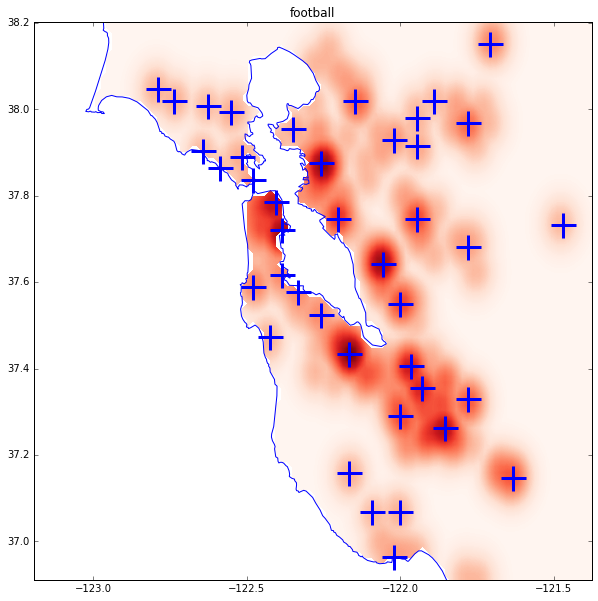

In [36]:
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot CA outline
plt.plot(x_coords,y_coords)
# plot KDE map
Z_new = np.power(Z/np.nanmax(Z),1/6)
levels = np.linspace(0,np.nanmax(Z_new), 150)
plt.contourf(X, Y, Z_new, levels=levels, cmap=plt.cm.Reds)
# plot maxima
plt.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', 
         markersize=25,markeredgewidth=3,markeredgecolor='b')
plt.xlim(limit_lng[0],limit_lng[1])
plt.ylim(limit_lat[0],limit_lat[1]) 
#
plt.title(keyword)
#
# outname = os.path.join('img/kde_peaks.png')
# plt.savefig(outname,bbox_inches='tight')

plt.show()

## Determine peak strength

The ranking of the peaks is done according to strength of the signal that belongs to each 'cluster'. Elements in the map are assigned a maximum / cluster they belong to in a nearest-neighbor fashion: Each grid element of the map is assigned to the maximum which it is closest to (euclidean). If the KDE value of the grid element is above a certain threshold (approx. given by the background 'noise' in the map), the value is added to the total weight of the cluster .  The final sum then gives the 'cluster strength' for each cluster.


In [37]:
# Get long/lat coordinates for each grid element
base_coords_map = np.array((X.reshape(local_maxima_map.shape),
                            Y.reshape(local_maxima_map.shape))).T
# Integrate peaks - Node mask
new_cut = 3.*cutoff
node_mask = node_dist(Z,base_coords_map,xy_maxima,new_cut)
# node_mask = node_dist(Z,xy_maxima_cut,new_cut)



In [38]:
# Turn label mask into label vector.
# Sum grid values for each class.
idx_list = []
sum_list = []
for index in np.unique(node_mask):
    if index == 0:
        pass
    else:
        idx_list.append(index)
        sum_list.append(np.sum(Z[node_mask == index]))
int_list = zip(idx_list,sum_list)        



In [39]:
# Sort list of (class, value) pairs according to cluster strength
def getKey(item):
    return item[1]
int_list_sorted = sorted(int_list, key=getKey,reverse=True)
# extract list of clusters after ordering accordint to cluster strength
cluster_list = [x[0] for x in int_list_sorted]


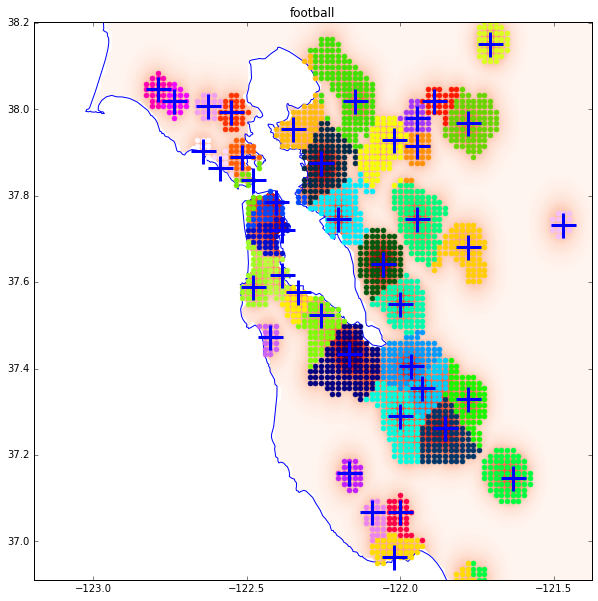

In [40]:
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
# plot CA outline
plt.plot(x_coords,y_coords)
# plot KDE map
Z_new = np.power(Z/np.nanmax(Z),1/6)
levels = np.linspace(0,np.nanmax(Z_new), 150)
plt.contourf(X, Y, Z_new, levels=levels, cmap=plt.cm.Reds)
#
plt.xlim(limit_lng[0],limit_lng[1])
plt.ylim(limit_lat[0],limit_lat[1]) 
#
plt.title(keyword)
# Set color map - different color for each cluster
colors = plt.cm.gist_ncar(np.linspace(0, 1, len(cluster_list)))
for k, col in zip(cluster_list, colors):
    # get data points belonging to class
    class_member_mask = (node_mask == k)
    tmp_coords = np.vstack([X[class_member_mask].ravel(),Y[class_member_mask].ravel()]).T
    # plot all points of current classa
    plt.plot(tmp_coords[:,0],tmp_coords[:,1], 'o', markerfacecolor=col,
             markeredgecolor=col,markersize=5)

# plot maxima
plt.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', 
         markersize=25,markeredgewidth=3,markeredgecolor='b')

# outname = os.path.join('img/kde_cluster.png')
# plt.savefig(outname,bbox_inches='tight')


plt.show()



## Correction of the cluster strength for population density

Intuitively, it is to be expected that the volume of image submission is - in general - spatially correlated with the popuation denisty. This means that areas of high population density can dominate the numbers for keyword-specific image submissions. 

In the framework of targeted advertisement this has two important consequences: the cost of running an advertisement in a specific zip code depends on the population denisty, i.e. the size of target audience in that zip code. However, if the subject matter of the advertisement is targeted to a specific interest group, it may be more important to reach a high fraction of consumers interested in the subject matter, than paying steeps premiums for high population density areas where only a small fraction of consumers will positively resonate with the advertisment.

To account for this potential mismatch and to maximize the 'bang for the advertisement buck', I correct the subject-specific cluster strength by 






In order to facilitate the rescaling by the total submission numbers, I have created a KDE map from *all* image records in the database. This map was created using exactly the same parameters as for the subject-specific subset. The KDE map from the full database can then be used to rescale each *cluster* as identified above by the total number of image submissions in this cluster.

The new ranking that results from this rescaling now reflects the *fraction* of image submissions that are relevant to the subject matter, rather than absolute numbers. In the zip codes corresponding to the top-ranked clusters the advertisement is likely to appeal to the largest percentage of the total consumer base. Thus,  maximizing the 'bang for the advertisement buck'. You don't have to pay for large groups of consumer which may not be interested in the subject matter of your advertisement.

In [ ]:
# Read KDE map for full database
tmp_reload = pickle.load( open("kde_all.pkl", "rb" ) )
X_all = tmp_reload['X']
Y_all = tmp_reload['Y']
Z_all = tmp_reload['Z']



## Presentation of the results

At this point, the code provides the coordinates of the maxima / cluster centers as well as their ranking. The interaction of the results happens in a dynamic web application written in Python using the Django web framwork.

The web application initilizes a Google Maps iframe via the Google Maps API. Markers on the map indicate the location of the cluster centers as well as their rank and provide additional information on the zip code the cluster center falls into (also retrived via the Google API).


## Future work

This project has been completed within about two weeks from the original idea, over data collection and developing the analysis strategy, to deployment as an interactive, database-driven web application running on Amazon AWS.



Account for possible mismachtes between where the image was taken vs. where the uploader (i.e. target audience) is located.

Allow for time dependencies / trends in time